In [1]:
# Run cell to import libraries and load data sets
import geopandas as gpd 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import contextily 
import mapclassify 
import folium
import aiohttp
import fsspec
import warnings
warnings.filterwarnings('ignore')
plt.style.use("ggplot")

# Load the COVID-19 data:
df_cases = pd.read_csv("https://raw.githubusercontent.com/babdelfa/project/refs/heads/main/cases_data.csv")
df_deaths = pd.read_csv("https://raw.githubusercontent.com/babdelfa/project/refs/heads/main/deaths_data.csv")    

# Load the GeoDataFrame containing United States geometry shapes (at a county-level):
county_shapes = "https://github.com/babdelfa/gis/blob/main/counties_geometry.zip?raw=true"
with fsspec.open(county_shapes) as counties_file:
    county_shapes = gpd.read_file(counties_file)

Hello. Please enter your name:  Darlene



Which state's COVID-19 information would you like to see?



 Enter the state:  Virginia



COVID-19 in Virginia: Key Statistics

Timeline:

Day 0 of COVID-19 in Virginia: March 8, 2020

 
Virginia Data by Year:

2020 (from March 8):

  - Total reported cases: 349,584
  - Average daily new cases: 1,169.18
  - Total reported deaths: 5,032
  - Average daily new deaths: 16.83

 
2021:

  - Total reported cases: 768,934
  - Average daily new cases: 2,106.67
  - Total reported deaths: 10,555
  - Average daily new deaths: 28.92

 
Overall Totals in Virginia (as of December 31, 2021):

  - Total cases: 1,118,518
  - Total deaths: 15,587

Darlene, please select a data visualization option for Virginia

 1. View four subplots showing COVID-19 trends in Virginia (2020-2021):

   * Bar Chart of Daily New Cases
   * Line Chart of Cumulative Cases Trend
   * Bar Chart of Daily New Deaths
   * Line Chart of Cumulative Deaths Trend
 
 2. View a choropleth map showing total reported cases and deaths by county in Virginia as of December 31, 2021.



Enter your choice (1 or 2):  1


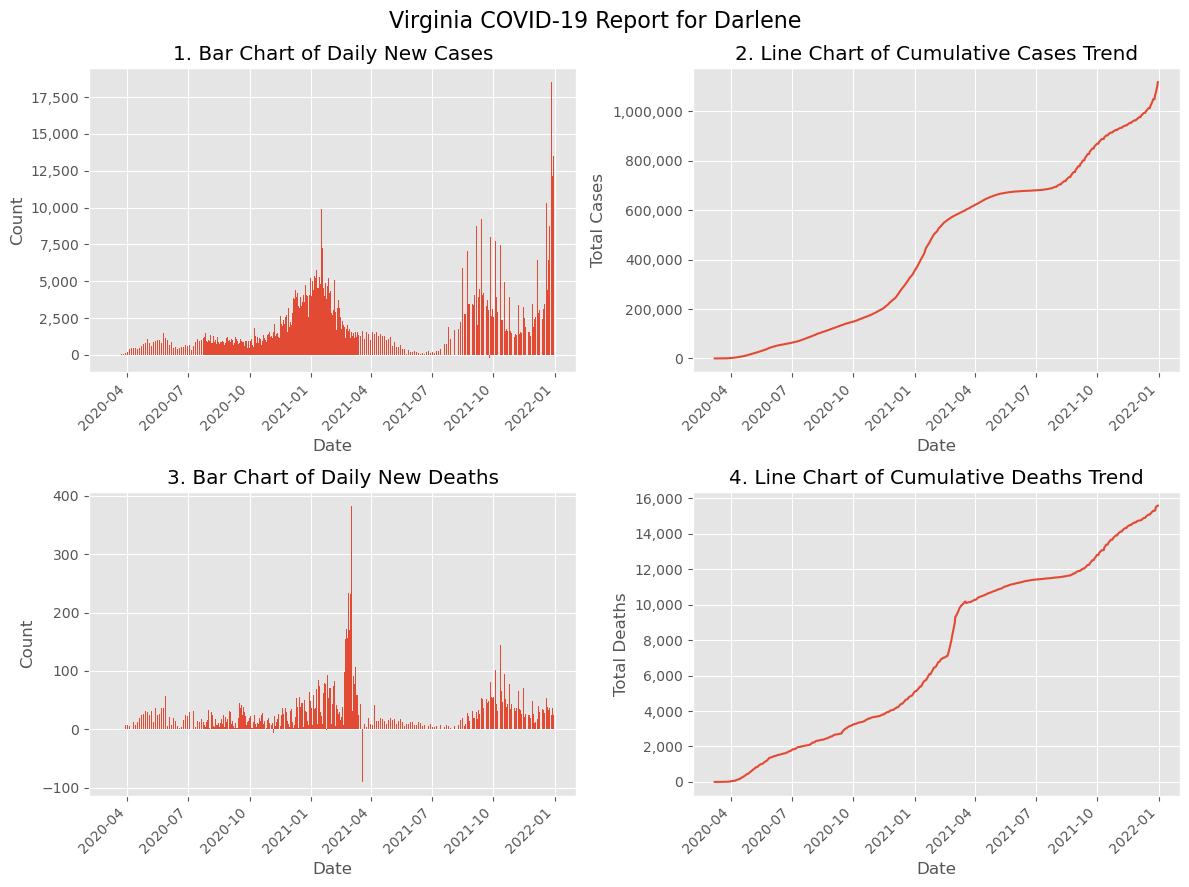

In [3]:
# Provide your project code below:

# 1. Prompt user for name and state
user_name = input("Hello. Please enter your name: ")

print("\nWhich state's COVID-19 information would you like to see?\n")

state_input = input(" Enter the state: ")
state_name = state_input.title() # Convert user input to Title Case to match dataset formatting

# 2. Convert wide-form case/death data to long-form

# Build list of data columns (those containing "/")
date_cols = []
for column_name in df_cases.columns:
    if "/" in column_name: 
        date_cols.append(column_name)

# Build list of ID columns for df_cases (all non-date columns)
id_cols_cases = []
for column_name in df_cases.columns:
    is_date = False
    for dcol in date_cols:
        if column_name == dcol:
            is_date = True
            break
    if not is_date:
        id_cols_cases.append(column_name)

# Build list of ID columns for df_deaths (all non-date columns for df_deaths)
id_cols_deaths = []
for column_name in df_deaths.columns:
    is_date = False
    for dcol in date_cols:
        if column_name == dcol:
            is_date = True
            break
    if not is_date:
        id_cols_deaths.append(column_name)

# Melt cases into long-form
cases_long = df_cases.melt(
    id_vars = id_cols_cases,
    value_vars=date_cols,
    var_name="Date",
    value_name="Confirmed"
)

# Melt deaths into long-form
deaths_long = df_deaths.melt(
    id_vars = id_cols_deaths,
    value_vars=date_cols,
    var_name="Date",
    value_name="Deaths"
)

# Convert date columns to datetime
cases_long["Date"] = pd.to_datetime(cases_long["Date"])
deaths_long["Date"] = pd.to_datetime(deaths_long["Date"])

cases_us = cases_long.copy()
deaths_us = deaths_long.copy()

# 3. State-level totals for each day

# Group to get total cases per state per date

state_cases = cases_us.groupby(["STATE", "Date"])["Confirmed"].sum().reset_index()
state_deaths = deaths_us.groupby(["state", "Date"])["Deaths"].sum().reset_index()

state_deaths = state_deaths.rename(columns={"state": "STATE"})

# 4. Timeline section - determine by Day 0

# Create a state-level DataFrame that includes both cases and deaths
state_covid_long = state_cases.merge(state_deaths, on=["STATE", "Date"], how="left")

# Keep only rows for the selected state and sort by date
state_data = state_covid_long[state_covid_long["STATE"] == state_name].copy()
state_data = state_data.sort_values("Date")

# Rename columns for convenience
state_data = state_data.rename(columns={"Date": "date", "Confirmed": "cases", "Deaths": "deaths"})

# Find the first date where the state reports more than 0 total cases (Day 0)
state_positive = state_data[state_data["cases"] > 0].copy()
day0_row = state_positive.iloc[0]
day0_date = day0_row["date"]

# Format the Day 0 date using month list
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
month_name = months[day0_date.month - 1]
day0_full_str = month_name + " " + str(day0_date.day) + ", " + str(day0_date.year)

day0_short_str = month_name + " " + str(day0_date.day)

print("\nCOVID-19 in " + state_name + ": Key Statistics\n")
print("Timeline:\n")
print("Day 0 of COVID-19 in " + state_name + ": " + day0_full_str + "\n")

# 5. Daily new cases and deaths

# Calculate daily new cases and deaths using the difference between days 
state_data["daily_cases"] = state_data["cases"].diff()
state_data["daily_deaths"] = state_data["deaths"].diff()

# Replace the NaN on the first day with that day's reported values
state_data["daily_cases"] = state_data["daily_cases"].fillna(state_data["cases"])
state_data["daily_deaths"] = state_data["daily_deaths"].fillna(state_data["deaths"])

# 6. Define date ranges for 2020, 2021, and overall
year2020_end = pd.Timestamp("2020-12-31")
year2021_start = pd.Timestamp("2021-01-01")
year2021_end = pd.Timestamp("2021-12-31")

overall_end_date = year2021_end
overall_end_str = "December 31, 2021"

# 2020 data: from Day 0 through Dec 31, 2020
data_2020 = state_data[(state_data["date"] >= day0_date) &
(state_data ["date"] <= year2020_end)].copy()

# 2021 data: from Jan 1, 2021 through Dec 31, 2021
data_2021 = state_data[(state_data["date"] >= year2021_start) & 
(state_data["date"] <= year2021_end)].copy()

# Overall data: Day 0 through Dec 31, 2021
overall_data = state_data[(state_data["date"] >= day0_date) &
(state_data["date"] <= overall_end_date)].copy()

# 7. Compute summary statistics for 2020, 2021, and overall
if len(data_2020) > 0:
    total_cases_2020 = int(data_2020["daily_cases"].sum())
    total_deaths_2020 = int(data_2020["daily_deaths"].sum())
    avg_daily_cases_2020 = round(data_2020["daily_cases"].mean(), 2)
    avg_daily_deaths_2020 = round(data_2020["daily_deaths"].mean(), 2)

else:
    total_cases_2020 = 0
    total_deaths_2020 = 0
    avg_daily_cases_2020 = 0.00
    avg_daily_deaths_2020 = 0.00

# 2021 totals and averages
if len(data_2021) > 0:
    total_cases_2021 = int(data_2021["daily_cases"].sum())
    total_deaths_2021 = int(data_2021["daily_deaths"].sum())
    avg_daily_cases_2021 = round(data_2021["daily_cases"].mean(), 2)
    avg_daily_deaths_2021 = round(data_2021["daily_deaths"].mean(), 2)

else:
    total_cases_2021 = 0
    total_deaths_2021 = 0
    avg_daily_cases_2021 = 0.00
    avg_daily_deaths_2021 = 0.00

# Overall totals and averages
total_cases_overall = int(overall_data["daily_cases"].sum())
total_deaths_overall = int(overall_data["daily_deaths"].sum())
avg_daily_cases_overall = round(overall_data["daily_cases"].mean(), 2)
avg_daily_deaths_overall = round(overall_data["daily_deaths"].mean(), 2)

# 8. Print yearly and overall statistics
print(" ")
print(state_name + " Data by Year:\n")

print("2020 (from " + day0_short_str + "):\n")
print("  - Total reported cases: " + format(total_cases_2020, ",.0f"))
print("  - Average daily new cases: " + format(avg_daily_cases_2020, ",.2f"))
print("  - Total reported deaths: " + format(total_deaths_2020, ",.0f"))
print("  - Average daily new deaths: " + format(avg_daily_deaths_2020, ",.2f") + "\n")

print(" ")
print("2021:\n")
print("  - Total reported cases: " + format(total_cases_2021, ",.0f"))
print("  - Average daily new cases: " + format(avg_daily_cases_2021, ",.2f"))
print("  - Total reported deaths: " + format(total_deaths_2021, ",.0f"))
print("  - Average daily new deaths: " + format(avg_daily_deaths_2021, ",.2f") + "\n")

print(" ")
print("Overall Totals in " + state_name + " (as of " + overall_end_str + "):\n")
print("  - Total cases: " + format(total_cases_overall, ",.0f"))
print("  - Total deaths: " + format(total_deaths_overall, ",.0f") + "\n")

# 9. Ask user which visualization they want to see
print(user_name + ", please select a data visualization option for " + state_name + "\n")

print(" 1. View four subplots showing COVID-19 trends in " + state_name + " (2020-2021):\n")
print("   * Bar Chart of Daily New Cases")
print("   * Line Chart of Cumulative Cases Trend")
print("   * Bar Chart of Daily New Deaths")
print("   * Line Chart of Cumulative Deaths Trend")

print(" ")
print(" 2. View a choropleth map showing total reported cases and deaths by county in " + state_name + " as of December 31, 2021.\n")

viz_choice = input("Enter your choice (1 or 2): ")

# 10. Four subplots for daily and cumulative trends

if viz_choice == "1":
    fig, axes = plt.subplots(2, 2, figsize=(12, 9))

    fig.suptitle(state_name + " COVID-19 Report for " + user_name, fontsize=16)

    # Use Day 0 through Dec 31, 2021
    plot_data = overall_data.copy()

    # 1. Bar Chart of Daily New Cases
    axes[0,0].bar(plot_data["date"], plot_data["daily_cases"])
    axes[0,0].set_title("1. Bar Chart of Daily New Cases")
    axes[0,0].set_xlabel("Date")
    axes[0,0].set_ylabel("Count")
    axes[0,0].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

    # 2. Line Chart of Cumulative Cases Trend
    axes[0,1].plot(plot_data["date"], plot_data["cases"])
    axes[0,1].set_title("2. Line Chart of Cumulative Cases Trend")
    axes[0,1].set_xlabel("Date")
    axes[0,1].set_ylabel("Total Cases")
    axes[0,1].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

    # 3. Bar Chart of Daily New Deaths
    axes[1,0].bar(plot_data["date"], plot_data["daily_deaths"])
    axes[1,0].set_title("3. Bar Chart of Daily New Deaths")
    axes[1,0].set_xlabel("Date")
    axes[1,0].set_ylabel("Count")
    axes[1,0].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

    # 4. Line Chart of Cumulative Deaths Trend
    axes[1,1].plot(plot_data["date"], plot_data["deaths"])
    axes[1,1].set_title("4. Line Chart of Cumulative Deaths Trend")
    axes[1,1].set_xlabel("Date")
    axes[1,1].set_ylabel("Total Deaths")
    axes[1,1].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

    # Rotate x-axis labels so dates are readable
    for row in axes:
        for ax in row:
            tick_labels = ax.get_xticklabels()
            for label in tick_labels:
                label.set_rotation(45)
                label.set_ha("right")
    
    plt.tight_layout()
    plt.show()


# If the user chooses option 2, show the choropleth map of counties

elif viz_choice == "2":
    print("\nChoropleth Map: Reported COVID-19 Cases as of December 31, 2021 in " + state_name + "\n")

    # Filter case data for chosen state and date
    counties_cases = cases_long.copy()
    counties_cases = counties_cases[counties_cases["STATE"] == state_name].copy()
    counties_cases = counties_cases[counties_cases["Date"] == year2021_end].copy()
    counties_cases = counties_cases[counties_cases["FIPS"].notna()].copy()

    # Filter death data for chosen state and date 
    counties_deaths = deaths_long.copy()
    counties_deaths = counties_deaths[counties_deaths["state"] == state_name].copy()
    counties_deaths = counties_deaths[counties_deaths["Date"] == year2021_end].copy()
    counties_deaths = counties_deaths[counties_deaths["fips"].notna()].copy()

    # Convert FIPS code to 5 digit strings for merging
    counties_cases["fips_str"] = counties_cases["FIPS"].astype(int).astype(str)
    counties_cases["fips_str"] = counties_cases["fips_str"].str.zfill(5)

    counties_deaths["fips_str"] = counties_deaths["fips"].astype(int).astype(str)
    counties_deaths["fips_str"] = counties_deaths["fips_str"].str.zfill(5)

    # Merge cases + deaths on FIPS
    counties_state = counties_cases.merge(counties_deaths[["fips_str", "Deaths"]], on="fips_str", how="left")

    # Rename columns for clarity
    counties_state = counties_state.rename(columns={"COUNTY": "County Name", "STATE": "State Name", "Confirmed": "Total Cases", "Deaths": "Total Deaths"})

    # Prepare county geometry for merging
    county_shapes["fips_str"] = county_shapes["FIPS_BEA"].astype(int).astype(str)
    county_shapes["fips_str"] = county_shapes["fips_str"].str.zfill(5)

    # Merge shapes with COVID data
    counties_geo = county_shapes.merge(counties_state, on="fips_str", how="right")

    # Keep only required columns
    keep_cols = ["County Name", "State Name", "Total Cases", "Total Deaths", "geometry"]
    counties_geo = counties_geo[keep_cols]

    # Choropleth map
    m = counties_geo.explore(
    column="Total Cases",
    cmap="YlOrRd",
    scheme="equalinterval",
    tooltip=["County Name", "State Name", "Total Cases", "Total Deaths"],
    legend=True
    )

    display(m)